# INTRODUCTION

The main processes on an image are:
  
1. **Undistort:** camera calibration matrix and distortion coefficients (using chessboard)
2. **Binarize:** color thresholding, gradient thresholding, etc.
3. **Birdeye:** prespective transform -> applied to binary image
4. **Polynomial curve fitting:** sliding window, histogram
5. **Compure offset:** from the center of lane
6. **Draw surface:** enclosed between two lanes

**For the video:** it's the same thing for the most part. It's just that in video (sequence of frames/images) we can infer lane lines based on previous frames.

***
# CAMERA CALIBRATION AND UNDISTORT

**STEPS:**

1. Number of inside corners: `nx`, `ny`
2. Make a list of calibration images: `for fname in glob.glob(camera_cal/*.jpg)`, `img = cv2.imread(fname)`
3. Convert to grayscale: `gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`
4. Find the chessboard corners: `ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)`
5. If corners found (`if ret:`), draw and display corners: `cv2.drawChessboardCorners(img, (nx, ny), corners, ret)`, `plt.imshow(img)`
6. Having object points and image points, we can use `cv2.calibrateCamera()` for calibration. It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.
7. Having camera matrix and distortion parameters, we can **_undistort_** images using `cv2.undistort(img, mtx, dist, None, newcameramtx)`, where `newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))` and `h,  w = img.shape[:2]`. 
8. We can use the **_ROI_** to crop the image: `x,y,w,h = roi`, `dst = dst[y:y+h, x:x+w]` and `cv2.imwrite('calibresult.png',dst)`.

**NOTE:** camera calibration should be only done once. So, in videos, onces you calibrated the camera first time/frame just save it and for the next frames just load that calibration.

- [OpenCV source](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html)
- [Other sources-1](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Other sources-2](https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html)
- [Other sources-3](https://www.mathworks.com/help/vision/ug/camera-calibration.html)

**On `numpy.meshgrid` & `numpy.mgrid`:** Refer to [this page](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

In [3]:
class Undistort:
    
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
    def calibrate(self, cal_img_pth):
        
        # 3D real world and image plance arrays
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        images = glob.glob('{}/*.jpg'.format(cal_img_pth))
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, 
                                                                               imgpoints, 
                                                                               gray.shape[::-1], 
                                                                               None, 
                                                                               None)
    def undistort(self, img_pth):
        return cv2.undistort(cv2.imread(img_pth), 
                             self.mtx, self.dist, 
                             newCameraMatrix=self.mtx)
    
    def show_undistorted(self, img_pth):
        fig, ax = plt.subplots(1, 2, figsize=(20,15))
        img = cv2.imread(img_pth)
        img_undistorted = self.undistort(img_pth)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Distorted')
        ax[1].set_title('Undistorted')
        plt.show()      

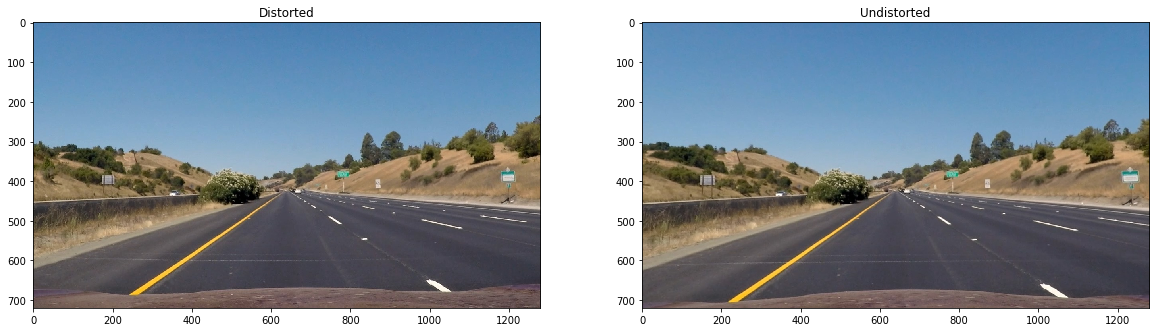

In [4]:
undist = Undistort(nx=9, ny=6)
undist.calibrate(cal_img_pth='camera_cal')
undist.show_undistorted(img_pth='test_images/straight_lines1.jpg')

***
# BINARIZE

Main steps here:
1. Color thresholing
2. Gradient thresholing (direction gradient, magnitude gradient, [Sobel](https://medium.com/datadriveninvestor/understanding-edge-detection-sobel-operator-2aada303b900))
> - Read on [Sobel vs Laplacian](http://www.aishack.in/tutorials/sobel-laplacian-edge-detectors/)
3. Combine both, and get a binary image.
4. We apply histogram equalization to improve the contrast of images.
5. Apply a light morphology to "fill the gaps" in the binary image.

## Color thresholding

- HLS
- HSV

## Gradient thresholding

- Canny edge detection, detects so many edges other than the lane lines.
- Sobel operator works on both `x` and `y` axis separately.
- Here is the $S_x$:

|-1|0 |1 |
|--|--|--|
|-2|0 |2 |
|-1|0 |1 |

- and $S_y$ is:

|1 |2 |1 |
|--|--|--|
|0 |0 |0 |
|-1|-2|-1|

- And the gradient magnitude is: $S = \sqrt{{S_x}^2 + {S_y}^2}$

- **NOTE1:** Sobel operator is a grayscale operator, so, images need to be converted into grayscale first.
- **NOTE2:** Sobel tends to identify non-edges. In order to reduce this error, it's better to apply Gaussian blurring before applying Sobel.

In [32]:
class Thresholding:
    
    def __init__(self, hsv_param, hls_param, sobel_param):
        self.hsv_param = hsv_param  #[min, max]
        self.hls_param = hls_param  #[min, max]
        self.sobel_param = sobel_param  #[kernel, threshold, max_val]
    
    def hsv_thresh(self, img, plot=False):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv_min = np.all(hsv > self.hsv_param[0], axis=2)
        hsv_max = np.all(hsv < self.hsv_param[1], axis=2)
        hsv_th = np.logical_and(hsv_min, hsv_max)
        if plot:
            plt.imshow(hsv_th, cmap='gray')
        return hsv_th
    
    def hls_thresh(self, img, plot=False):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        hls_min = np.all(hls > self.hls_param[0], axis=2)
        hls_max = np.all(hls < self.hls_param[1], axis=2)
        hls_th = np.logical_and(hls_min, hls_max) 
        if plot:
            plt.imshow(hls_th, cmap='gray')
        return hls_th
    
    def sobel(self, img, plot=False):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_param[0])
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_param[0])
        sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
        sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag)*255)
        _, sobel_mag = cv2.threshold(sobel_mag, 
                                     sobel_param[1], 
                                     sobel_param[2], 
                                     cv2.THRESH_BINARY)
        if plot:
            plt.imshow(sobel_mag, cmap='gray')
        return sobel_mag
    
    def plot_comparison(self, img1, img2):
        fig, ax = plt.subplots(1, 2, figsize=(20,15))
        ax[0].imshow(img1)
        ax[1].imshow(img2)
        plt.show()
    
    def combine_thresholds(self, img, hist_eq=True, plot=False):
        h, w = img.shape[:2]
        binary = np.zeros((h, w))
        hsv_th = self.hsv_thresh(img)
        hls_th = self.hls_thresh(img)
        binary = np.logical_or(binary, hsv_th)
        binary = np.logical_or(binary, hls_th)
        if hist_eq:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            eq_global = cv2.equalizeHist(gray)
            _, hist_eq = cv2.threshold(eq_global, 
                                       thresh=250, 
                                       maxval=255, 
                                       type=cv2.THRESH_BINARY)
            binary = np.logical_or(binary, hist_eq)
        sobel_th = self.sobel(img)
        binary = np.logical_or(binary, sobel_th)
        kernel = np.ones((5, 5), np.uint8)*1
        binary = cv2.morphologyEx(binary.astype(np.uint8), 
                                  cv2.MORPH_CLOSE, kernel)
        if plot:
            plt.figure(figsize=(15,5))
            plt.imshow(binary) 
        return binary

In [33]:
hls_min_thres = np.array([0, 0, 90])
hls_max_thres = np.array([255, 255, 255])
hsv_min_thres = np.array([0, 70, 70])
hsv_max_thres = np.array([50, 255, 255])
hls_param = [hls_min_thres, hls_max_thres]
hsv_param = [hsv_min_thres, hsv_max_thres]
sobel_kernel_size = 1
sobel_threshold = 50
sobel_max_val = 1
sobel_param = [sobel_kernel_size, 
               sobel_threshold, 
               sobel_max_val]
thresh = Thresholding(hls_param, hsv_param, sobel_param)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

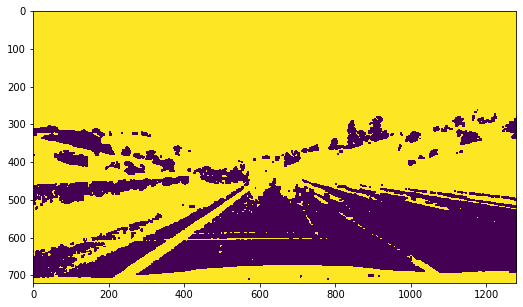

In [34]:
thresh.combine_thresholds(img, plot=True)

***
# Perspective Transform

For perspective transformation, you need a 3x3 transformation matrix. Straight lines will remain straight even after the transformation. To find this transformation matrix, you need 4 points on the input image and corresponding points on the output image. Among these 4 points, 3 of them should not be collinear. Then transformation matrix can be found by the function `cv2.getPerspectiveTransform`. Then, using `cv2.warpPerspective`, we can perform the transform.

Check out the example below (from OpenCV website):

```python

img = cv2.imread('sudokusmall.png')
rows,cols,ch = img.shape

pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()
```

![](myimg/perspective.jpg)

In [52]:
class PerspectiveTransform:
    
    def __init__(self, img_pth, src=None, dst=None):
        img = cv2.imread(img_pth)
        h, w = img.shape[:2]
        self.h, self.w = h, w
        if src is None:
            self._src = np.float32([[w, h-10],    # br
                                    [0, h-10],    # bl
                                    [546, 460],   # tl
                                    [732, 460]])  # tr
        else:
            self._src = src
        if dst is None:
            self._dst = np.float32([[w, h],       # br
                                    [0, h],       # bl
                                    [0, 0],       # tl
                                    [w, 0]])      # tr
        else:
            self._dst = dst
    
    @property
    def src_dst(self):
        return self._src, self._dst
    
    @src_dst.setter
    def src_dst(self, src, dst):
        self._src = src
        self._dst = dst
    
    def transform(self):
        M = cv2.getPerspectiveTransform(self._src, self._dst)
        Minv = cv2.getPerspectiveTransform(self._dst, self._src)
        return cv2.warpPerspective(img, M, (self.w, self.h), flags=cv2.INTER_LINEAR)

In [53]:
img_pth = 'test_images/straight_lines2.jpg'

# a = PerspectiveTransform(img_pth)

img_pt = PerspectiveTransform(img_pth).transform()

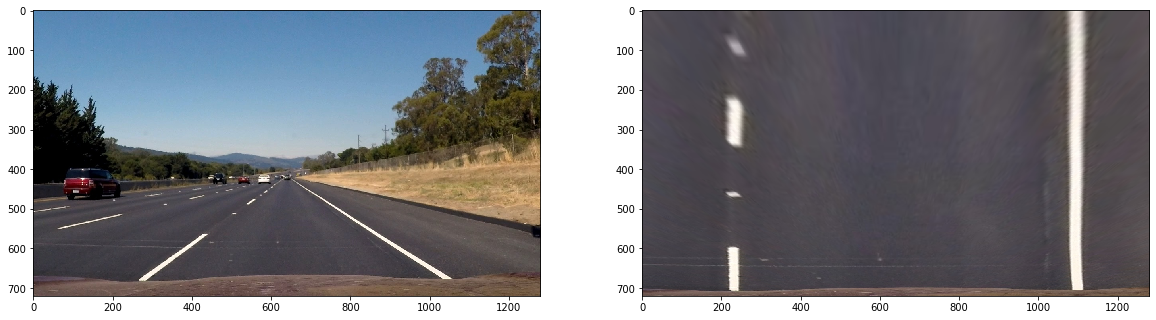

In [54]:
img = cv2.imread(img_pth)
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_pt, cv2.COLOR_BGR2RGB))
plt.show()

In [92]:
%matplotlib inline

In [122]:
nx = 9
ny = 6

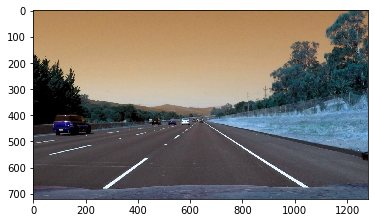

In [36]:
img = cv2.imread('test_images/straight_lines2.jpg')
plt.imshow(img)

In [158]:
# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)

In [159]:
# Convert undistorted image to grayscale
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

In [160]:
# Search for corners in the grayscaled image
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

In [161]:
# of course, not a chessboard so no corners
type(corners)

NoneType

In [162]:
offset = 100 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

In [163]:
h, w = img.shape[:2]

src = np.float32([[w, h-10],    # br
                  [0, h-10],    # bl
                  [546, 460],   # tl
                  [732, 460]])  # tr
dst = np.float32([[w, h],       # br
                  [0, h],       # bl
                  [0, 0],       # tl
                  [w, 0]])      # tr

In [164]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

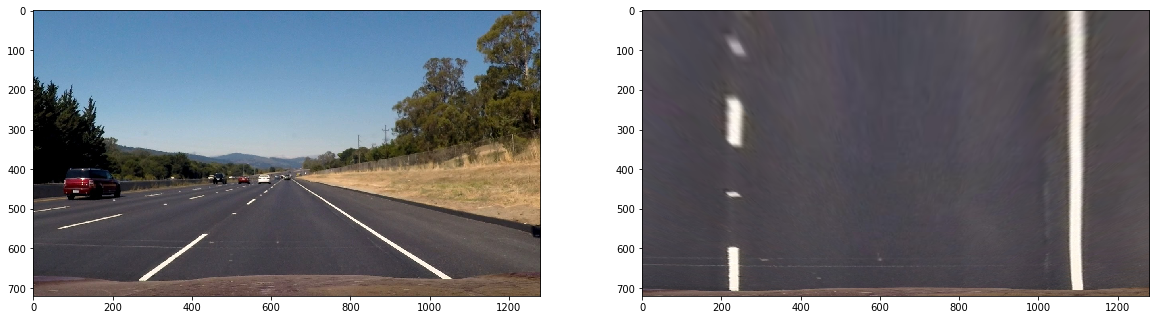

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

# Finding Lane Lines & Measuring Curvature

## Simple Histogram

In [166]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

In [167]:
bottom_half = warped[warped.shape[0]//2:,:]

In [168]:
histogram = np.sum(bottom_half, axis=0)

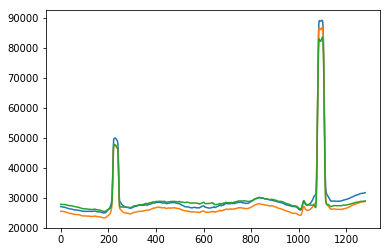

In [169]:
plt.plot(histogram)

## Sliding Window

## Sliding window convolution

## Search From prior